In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from scipy.stats import norm


from scipy.stats import multivariate_normal as mvn

In [2]:
N = 1000
D = 2
rs = np.random.RandomState(1)
X = rs.randn(N, D)
W_real = rs.randn(D)
print "Real W", W_real
Y = rs.binomial(1, sigmoid(np.dot(X, W_real)))

Real W [ 0.48951662  0.23879586]


In [3]:
def elbo_grad(z_sample, mu, sigma):
    score_mu = (z_sample - mu)/ sigma
    score_logsigma = (-1/(2 * sigma) + np.power((z_sample - mu), 2) / (2 * np.power(sigma, 2))) * sigma

    likelihood = np.sum(Y * np.log(sigmoid(np.dot(X, z_sample))) + (1 - Y) * np.log(1 - sigmoid(np.dot(X, z_sample))))
    prior = np.sum(norm.logpdf(z_sample, np.zeros(D), np.ones(D)))
    log_p = likelihood + prior
    log_q = np.sum(norm.logpdf(z_sample, mu, np.sqrt(sigma)))
    return np.concatenate([score_mu, score_logsigma]) * (log_p - log_q)

In [4]:
%matplotlib inline
from IPython import display

def plot_isocontours(func, xlimits=[-1.5, 1.5], ylimits=[-1.5, 1.5], numticks=101):
     x = np.linspace(*xlimits, num=numticks)
     y = np.linspace(*ylimits, num=numticks)
     X, Y = np.meshgrid(x, y)
     zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
     Z = zs.reshape(X.shape)
     plt.contour(X, Y, Z)

def callback(mu, log_sigma):
    plt.clf()
    variational_contour = lambda x: mvn.pdf(x, mu, np.diag(np.exp(2*log_sigma)))
    plot_isocontours(variational_contour)
    #plt.pause(1.0/30.0)

    plt.scatter([W_real[0]], [W_real[1]])
    
    display.clear_output(wait=True)
    display.display(plt.gcf())


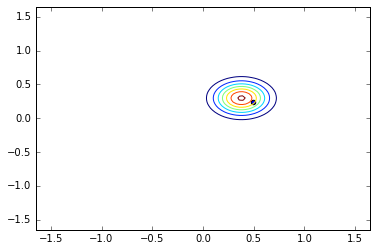

[-1.75213904 -1.83284065]
[-1.75044891 -1.83238682]
[-1.75356311 -1.8305647 ]
[-1.7542608  -1.83389482]
[-1.75495028 -1.83319186]
[-1.75589937 -1.8329207 ]
[-1.75571828 -1.83279257]
[-1.75772971 -1.83343643]
[-1.75963065 -1.83227508]
[-1.75907512 -1.83207983]


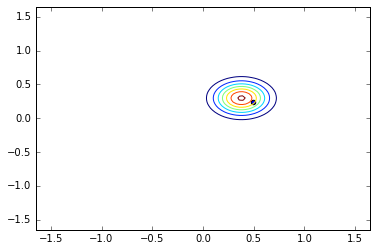

In [5]:
rs = np.random.RandomState(1)
S = 100
n_iter = 1000
eta = 0.001

mu = rs.randn(D)
log_sigma = rs.randn(D)

#print log_sigma
for t in xrange(n_iter):
    if t % 10 == 0:
        print t, log_sigma
        callback(mu, log_sigma)
        
    for i, s in enumerate(log_sigma):
        if s < -10:
            log_sigma[i] = -10

    print log_sigma
    sigma = np.exp(log_sigma)
    #print sigma
    samples = np.array([rs.normal(mu, np.sqrt(sigma)) for s in xrange(S)])

    grad_estimate = np.mean(np.array([elbo_grad(z_sample, mu, sigma) for z_sample in samples]), axis=0)
 
    mu += (eta / (5.0 + np.sqrt(t))) * grad_estimate[:D]
    log_sigma += (eta / (5.0 + np.sqrt(t))) * grad_estimate[D:]

